#  Gold 18k Opportunity Finder (Cash Converters)

This notebook scrapes 18k gold jewelry listings from Cash Converters Spain (Canary Islands Website) and generates a dataset to quickly detect "good deals" based on:

- Price (€)
- Weight (grams)
- €/gram ratio
- Stone type (preferably no stones)
- Shop availability

 Educational purpose only. Data may change. Scraping is performed with delays to avoid overload.


In [62]:
!pip -q install beautifulsoup4 lxml


In [63]:
import time
import re
from datetime import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlencode


##  Scraping settings
You can control how many pages to scrape and the delay between requests.


In [64]:
BASE = "https://www.cashconverters.es"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/120 Safari/537.36"
    ),
    "Accept-Language": "es-ES,es;q=0.9",
    "X-Requested-With": "XMLHttpRequest",
}

MAX_PAGES = 5
PAGE_SIZE = 24
SLEEP_S = 0.8
TIMEOUT_S = 15


##  Scraper functions
Includes:
- Listing scraping (AJAX search)
- Product parsing (price, grams, stone type)
- Store modal parsing (address and opening hours)


In [65]:
import time
import re
import json
from datetime import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlencode

# ---------------------------------------------------------
# GLOBAL CONFIG
# ---------------------------------------------------------
BASE = "https://www.cashconverters.es"
TIMEOUT_S = 15

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/120 Safari/537.36"
    ),
    "Accept-Language": "es-ES,es;q=0.9",
    "X-Requested-With": "XMLHttpRequest",
}

# ---------------------------------------------------------
# PRICE PARSER (Spanish format: 1.234,95 €)
# ---------------------------------------------------------
def parse_price_es(value):
    if value is None:
        return None

    s = str(value).replace("\xa0", " ").replace("€", "").strip()
    s = re.sub(r"[^0-9\.,]", "", s)

    if s == "":
        return None

    if "," in s and "." in s:
        if s.rfind(",") > s.rfind("."):
            s = s.replace(".", "").replace(",", ".")
        else:
            s = s.replace(",", "")
    else:
        if "," in s:
            s = s.replace(",", ".")

    try:
        return float(s)
    except:
        return None



# ---------------------------------------------------------
# 1) LISTING (AJAX endpoint)
# ---------------------------------------------------------
def fetch_listing_page(session, start=0, sz=24):
    url = (
        "https://www.cashconverters.es/on/demandware.store/"
        "Sites-CashConvertersCI-Site/es_ES/Search-ShowAjax"
        f"?cgid=1470&prefn1=cash_1192&prefv1=Oro%2018k&start={start}&sz={sz}"
    )
    r = session.get(url, timeout=TIMEOUT_S)
    r.raise_for_status()
    return r.text


def parse_listing_products(html):
    soup = BeautifulSoup(html, "html.parser")
    tiles = soup.select(".product, .product-tile")

    items = []
    for t in tiles:
        # Product URL
        product_url = None
        for a in t.select("a[href]"):
            href = a.get("href", "")
            if "/ic/es_ES/segunda-mano/" in href:
                product_url = urljoin(BASE, href)
                break

        if not product_url:
            continue

        # Product name
        name = None
        a0 = t.select_one("a[href]")
        if a0:
            name = a0.get_text(" ", strip=True)

        # Listing price
        text = t.get_text(" ", strip=True)
        m = re.search(r"(\d{1,3}(?:\.\d{3})*(?:,\d{2})?)\s?€", text)
        listing_price = parse_price_es(m.group(1)) if m else None

        items.append(
            {
                "name": name,
                "price_eur_listing": listing_price,
                "url": product_url,
            }
        )

    return pd.DataFrame(items).drop_duplicates(subset=["url"]).reset_index(drop=True)


# ---------------------------------------------------------
# 2) PRODUCT PAGE (price, grams, stone type)
# ---------------------------------------------------------
def _extract_price_from_jsonld(soup):
    scripts = soup.find_all("script", {"type": "application/ld+json"})
    for sc in scripts:
        raw = sc.string
        if not raw:
            continue

        try:
            data = json.loads(raw)
        except Exception:
            continue

        candidates = data if isinstance(data, list) else [data]
        for obj in candidates:
            if not isinstance(obj, dict):
                continue

            offers = obj.get("offers")

            if isinstance(offers, dict):
                price = offers.get("price")
                p = parse_price_es(price)
                if p:
                    return p

            elif isinstance(offers, list):
                for off in offers:
                    if isinstance(off, dict):
                        price = off.get("price")
                        p = parse_price_es(price)
                        if p:
                            return p

    return None


def _extract_price_from_meta(soup):
    # itemprop=price content="..."
    tag = soup.find(attrs={"itemprop": "price"})
    if tag:
        p = parse_price_es(tag.get("content") or tag.get_text(" ", strip=True))
        if p:
            return p

    # Other meta tags sometimes used
    for prop in ["product:price:amount", "og:price:amount", "twitter:data1"]:
        tag = soup.find("meta", attrs={"property": prop}) or soup.find("meta", attrs={"name": prop})
        if tag:
            p = parse_price_es(tag.get("content"))
            if p:
                return p

    return None


def _extract_price_from_visible_text(soup):
    """
    Último recurso: buscar valores de precio en texto visible.
    Elegimos el MAYOR precio encontrado (porque la página puede tener más de un €).
    """
    text = soup.get_text(" ", strip=True)

    matches = re.findall(r"(\d{1,3}(?:\.\d{3})*(?:,\d{2})?)\s?€", text)
    prices = [parse_price_es(x) for x in matches]
    prices = [p for p in prices if p is not None]

    if not prices:
        return None

    # Elegimos el máximo para evitar capturar precios pequeños "fake" (envío, etc.)
    return max(prices)


def parse_product_details(html):
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(" ", strip=True).lower()

    # 1) Product price (robusto)
    product_price = (
        _extract_price_from_jsonld(soup)
        or _extract_price_from_meta(soup)
        or _extract_price_from_visible_text(soup)
    )
    # 2) Weight grams (permite coma)
    grams = None
    mg = re.search(r"gramos:\s*([0-9]+(?:[.,][0-9]+)?)", text)
    if mg:
        grams_str = mg.group(1).replace(",", ".")
        try:
            grams = float(grams_str)
        except:
            grams = None

    # 3) Stone type
    stone_type = None
    mp = re.search(r"tipo de piedra:\s*([^:]+?)\s+(marca:|categoría:|estado:)", text)
    if mp:
        stone_type = mp.group(1).strip()

    return product_price, grams, stone_type


# ---------------------------------------------------------
# 3) STORE MODAL (address + opening hours)
# ---------------------------------------------------------
def get_shopcode_from_product_url(product_url):
    pid = product_url.split("/")[-1].replace(".html", "")
    return pid.split("_")[0]


def fetch_store_modal(session, shop_code):
    base = (
        "https://www.cashconverters.es/on/demandware.store/"
        "Sites-CashConvertersCI-Site/es_ES/StoreSelector-StoreAvaibilityModal"
    )
    params = {"shopCode": shop_code, "format": "ajax"}
    url = base + "?" + urlencode(params)

    r = session.get(url, timeout=TIMEOUT_S)
    r.raise_for_status()
    return r.text


def parse_store_modal(html):
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(" ", strip=True)

    # Address heuristic: extract around postal code
    store_address = None
    postal_match = re.search(r"\b\d{5}\b", text)
    if postal_match:
        idx = postal_match.start()
        store_address = text[max(0, idx - 120) : idx + 120].strip()

    # Opening hours
    opening_hours = None
    mh = re.search(r"(lunes\s*-\s*sábado:\s*\d{2}:\d{2}\s*-\s*\d{2}:\d{2})", text.lower())
    if mh:
        opening_hours = mh.group(1)

    return store_address, opening_hours


# ---------------------------------------------------------
# 4) MAIN SCRAPER
# ---------------------------------------------------------
def run_scraper(max_pages=3, page_size=24, sleep_s=0.8):
    session = requests.Session()
    session.headers.update(HEADERS)

    all_rows = []
    start = 0

    for page in range(max_pages):
        print(f"\n📄 Listing page {page + 1}/{max_pages} | start={start}")

        listing_html = fetch_listing_page(session, start=start, sz=page_size)
        df_list = parse_listing_products(listing_html)

        print("✅ Products found:", len(df_list))
        if len(df_list) == 0:
            break

        for _, row in df_list.iterrows():
            product_url = row["url"]
            name = row["name"]

            print("  🔎", name)

            # Product page
            try:
                rp = session.get(product_url, timeout=TIMEOUT_S)
                rp.raise_for_status()
                product_price, grams, stone_type = parse_product_details(rp.text)
            except Exception:
                product_price, grams, stone_type = None, None, None

            # Store modal
            shop_code = get_shopcode_from_product_url(product_url)
            try:
                modal_html = fetch_store_modal(session, shop_code)
                store_address, opening_hours = parse_store_modal(modal_html)
            except Exception:
                store_address, opening_hours = None, None

            all_rows.append(
                {
                    "name": name,
                    "url": product_url,
                    "price_eur_listing": row["price_eur_listing"],
                    "price_eur_product": product_price,
                    "grams": grams,
                    "stone_type": stone_type,
                    "shop_code": shop_code,
                    "store_address": store_address,
                    "opening_hours": opening_hours,
                }
            )

            time.sleep(sleep_s)

        start += page_size

    df = pd.DataFrame(all_rows)
    df["scrape_datetime"] = datetime.now().isoformat()
    return df


##  Run scraper
This will scrape product listings and product details.


In [66]:
df_raw = run_scraper(max_pages=MAX_PAGES, page_size=PAGE_SIZE, sleep_s=SLEEP_S)

print("Scraped rows:", len(df_raw))
df_raw.head(10)



📄 Listing page 1/5 | start=0
✅ Products found: 24
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 

📄 Listing page 2/5 | start=24
✅ Products found: 24
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 

📄 Listing page 3/5 | start=48
✅ Products found: 24
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 

📄 Listing page 4/5 | start=72
✅ Products found: 24
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 

📄 Listing page 5/5 | start=96
✅ Products found: 24
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
  🔎 
Scraped rows: 120


,name,url,price_eur_listing,price_eur_product,grams,stone_type,shop_code,store_address,opening_hours,scrape_datetime
0,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E472066_0.html,236.95,236.95,2.28,sin piedra,CC053,"Producto único disponible en C/ Aridane con Cerruda, 12 - Las Palmas de Gran...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
1,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E472022_0.html,450.95,450.95,4.46,sin piedra,CC053,"Producto único disponible en C/ Aridane con Cerruda, 12 - Las Palmas de Gran...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
2,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E473452_0.html,454.95,454.95,4.65,sin piedra,CC053,"Producto único disponible en C/ Aridane con Cerruda, 12 - Las Palmas de Gran...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
3,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E473238_0.html,539.95,539.95,5.54,sin piedra,CC053,"Producto único disponible en C/ Aridane con Cerruda, 12 - Las Palmas de Gran...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
4,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E465934_0.html,347.95,347.95,3.54,sin piedra,CC053,"Producto único disponible en C/ Aridane con Cerruda, 12 - Las Palmas de Gran...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
5,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC047_E578223_0.html,506.95,506.95,5.26,sin piedra,CC047,"único disponible en Avda. General Mas de Gaminde, 47B - Las Palmas de Gran C...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
6,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC047_G18355_0.html,1695.95,1695.95,13.90,None,CC047,"único disponible en Avda. General Mas de Gaminde, 47B - Las Palmas de Gran C...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
7,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC089_E334404_0.html,46.95,46.95,0.43,sin piedra,CC089,"Producto único disponible en C/ Francisco Gourie, 22 - Las Palmas de Gran Ca...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
8,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E470714_0.html,604.95,604.95,6.23,sin piedra,CC053,"Producto único disponible en C/ Aridane con Cerruda, 12 - Las Palmas de Gran...",lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659
9,,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC101_E13702_0.html,224.95,224.95,2.24,sin piedra,CC101,Producto único disponible en Calle Domingo Ramirez Ferrera n3 CP 35500 Arre...,lunes - sábado: 09:00 - 20:00,2026-01-16T00:13:27.113659


## Data cleaning + feature engineering

We add:
- eur_per_gram
- has_stones / no_stones heuristic
- filters for missing values


In [67]:
df = df_raw.copy()

# Normalize stone_type text
df["stone_type_clean"] = df["stone_type"].astype(str).str.lower().str.strip()

# Heuristic: detect stones
# (If stone_type missing -> unknown; if says "ninguna" -> no stones)
df["no_stones"] = df["stone_type_clean"].apply(
    lambda x: True if ("ninguna" in x or "sin" in x) else False
)

# Compute eur_per_gram safely
df["eur_per_gram"] = df.apply(
    lambda x: x["price_eur_product"] / x["grams"]
    if pd.notnull(x["price_eur_product"]) and pd.notnull(x["grams"]) and x["grams"] > 0
    else None,
    axis=1,
)

df.head(10)

# Si el product price falla (None o demasiado bajo) usamos listing como fallback
def choose_best_price(row):
    p_prod = row["price_eur_product"]
    p_list = row["price_eur_listing"]

    # Si no hay uno, usa el otro
    if pd.isna(p_prod) and pd.notna(p_list):
        return p_list
    if pd.isna(p_list) and pd.notna(p_prod):
        return p_prod

    # Si ambos existen, valida
    if pd.notna(p_prod) and pd.notna(p_list):
        # Si el product price es demasiado bajo vs listing (ej: captura un número incorrecto)
        if p_prod < 0.6 * p_list:
            return p_list
        # Si difieren un poco, confía en product (si es razonable)
        return p_prod

    return None

df["price_eur_final"] = df.apply(choose_best_price, axis=1)


##  Best deals ranking

Goal: find items with lowest €/gram (more gold for less money)


In [68]:
df_deals = df.dropna(subset=["eur_per_gram", "grams", "price_eur_product"]).copy()

df_deals = df_deals.sort_values("eur_per_gram", ascending=True).reset_index(drop=True)

df_deals[["name", "price_eur_product", "grams", "eur_per_gram", "stone_type", "shop_code"]].head(15)


,name,price_eur_product,grams,eur_per_gram,stone_type,shop_code
0,,367.95,4.45,82.685393,None,CC053
1,,493.95,5.80,85.163793,sin piedra,CC053
2,,131.95,1.53,86.241830,sin piedra,CC089
3,,617.95,6.79,91.008837,sin piedra,CC053
4,,364.95,3.96,92.159091,sin piedra,CC047
5,,323.95,3.50,92.557143,sin piedra,CC053
6,,271.95,2.93,92.815700,sin piedra,CC053
7,,222.95,2.37,94.071730,sin piedra,CC053
8,,185.95,1.97,94.390863,sin piedra,CC053
9,,506.95,5.26,96.378327,sin piedra,CC047


##  Best deals WITHOUT stones
This is the most useful shortlist if you want maximum gold weight for the price.


In [69]:
df_no_stones = df_deals[df_deals["no_stones"] == True].copy()

df_no_stones[["name", "price_eur_product", "grams", "eur_per_gram", "stone_type", "url"]].head(20)


,name,price_eur_product,grams,eur_per_gram,stone_type,url
1,,493.95,5.80,85.163793,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E468778_0.html
2,,131.95,1.53,86.241830,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC089_E327733_0.html
3,,617.95,6.79,91.008837,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E467797_0.html
4,,364.95,3.96,92.159091,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC047_E577035_0.html
5,,323.95,3.50,92.557143,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E466576_0.html
6,,271.95,2.93,92.815700,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E468077_0.html
7,,222.95,2.37,94.071730,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E468669_0.html
8,,185.95,1.97,94.390863,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E468666_0.html
9,,506.95,5.26,96.378327,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC047_E578223_0.html
10,,604.95,6.23,97.102729,sin piedra,https://www.cashconverters.es/ic/es_ES/segunda-mano/CC053_E470714_0.html


##  Quick summary stats


In [70]:
summary = {
    "total_scraped": len(df),
    "with_grams": df["grams"].notna().sum(),
    "with_price": df["price_eur_product"].notna().sum(),
    "with_eur_per_gram": df["eur_per_gram"].notna().sum(),
    "no_stones_count": df["no_stones"].sum(),
    "best_eur_per_gram": df_deals["eur_per_gram"].min() if len(df_deals) else None,
}

pd.DataFrame([summary])


,total_scraped,with_grams,with_price,with_eur_per_gram,no_stones_count,best_eur_per_gram
0,120,120,120,120,102,82.685393


##  Export datasets
- Full dataset
- Best deals shortlist
- Best deals (no stones) shortlist


In [71]:
df.to_csv("gold18k_cashconverters_full.csv", index=False)
df_deals.head(100).to_csv("gold18k_cashconverters_top100.csv", index=False)
df_no_stones.head(100).to_csv("gold18k_cashconverters_no_stones_top100.csv", index=False)

print("✅ Files saved:")
print("- gold18k_cashconverters_full.csv")
print("- gold18k_cashconverters_top100.csv")
print("- gold18k_cashconverters_no_stones_top100.csv")


✅ Files saved:
- gold18k_cashconverters_full.csv
- gold18k_cashconverters_top100.csv
- gold18k_cashconverters_no_stones_top100.csv


##  €/gram distribution
Lower is better.


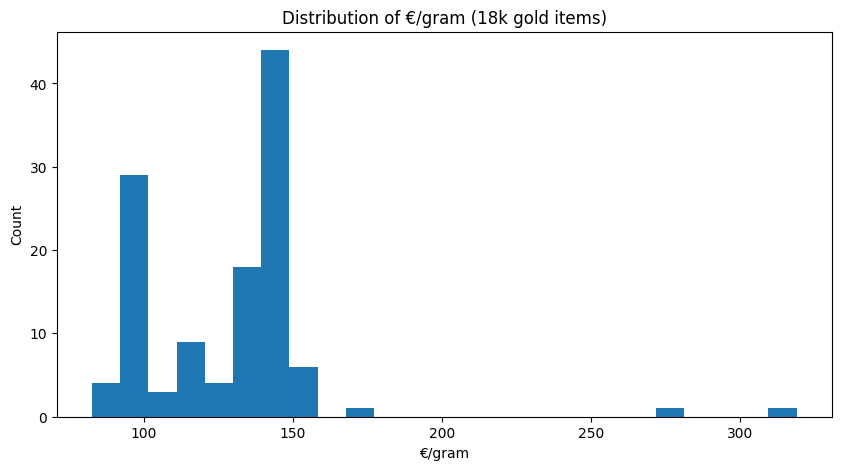

In [72]:
import matplotlib.pyplot as plt

df_plot = df_deals.dropna(subset=["eur_per_gram"]).copy()

plt.figure(figsize=(10, 5))
plt.hist(df_plot["eur_per_gram"], bins=25)
plt.title("Distribution of €/gram (18k gold items)")
plt.xlabel("€/gram")
plt.ylabel("Count")
plt.show()
